In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

def open_files_in_dir(path):
    files = {}
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                files[entry.name.split('.')[0]] = pd.read_csv(entry)
    return files

basepath = 'C:/datasets/sales/'
files_sales = open_files_in_dir(basepath)
print(files_sales.keys())

dict_keys(['items', 'item_categories', 'sales_train', 'sample_submission', 'shops', 'test'])


## DQC class

At first, we can create class which will encapsulate some information about given files.

In [3]:
class DQC:
    
    def __init__(this, our_files):
        this.files = our_files
    
    def print_head(this, table_name):
        print(this.files[table_name].head())
        
    def are_there_any_duplicates(this):
        
        sum_of_dupl = 0
        tables = []
        
        for file in this.files:
            if this.files[file].duplicated().sum()!=0:
                tables.append(file)
                sum_of_dupl += this.files[file].duplicated().sum()
                
            else: sum_of_dupl += this.files[file].duplicated().sum()
                
        return f"The amount of duplicated data in all the tables: {sum_of_dupl}; Tables with duplicates: {tables}"
    
    def are_there_any_null_values(this):
        
        info = []
        
        for file in this.files:
            info.append(f"Table {file} contains {this.files[file].isna().sum().sum()} empty raws")
            
        return info
    
    def are_there_any_outliers(this):
        
        num_columns = {}
        for file in this.files:
            temp_table = this.files[file]
            for col in temp_table.columns:
                if (temp_table[col].dtype != "O") and ('id' not in col and col!='ID'):
                    if (file in num_columns.keys()):
                        num_columns[file].append(col)
                    else:
                        num_columns[file] = [col]
                        
        for file in this.files:
            if file in num_columns.keys():
                plt.figure()
                plt.title(f"Boxplot for {file} table")
                sns.boxplot(data = this.files[file][num_columns[file]])
            else:
                print(f'There are no numeric columns in {file} table')
        
    def columns_type_and_structure(this):
        
        for file in this.files:
            print(f'Table "{file}" with {this.files[file].shape[0]} values:')
            print(this.files[file].dtypes)
            print('\n')
            
    def are_there_any_negative_values(this):
        
        temp_table = this.files['sales_train']
        for col in temp_table.columns:
            if temp_table[col].dtype != "O":
                negs =  len(temp_table[temp_table[col]<0])
                print(f"The precent of negative values in sales_train table in {col} column: {round(negs*100/len(temp_table),5)}")
                if negs!=0: 
                    print('\n')
                    print(temp_table[temp_table[col]<0].head())
                    print('\n')
                    
    def the_returned(this):
        
        sales_train = this.files['sales_train']
        returned = sales_train[sales_train['item_cnt_day']<=0]
        
        return returned
    
    def is_actually_a_return(this):
        
        returned = this.the_returned()
        colors = sns.color_palette('pastel')[0:5]
        
        plt.figure()
        plt.title('Item ids:')
        plt.pie(returned['item_id'].value_counts().head(), labels = returned['item_id'].value_counts().head().index, colors = colors)
        
        plt.figure()
        plt.title('Shop ids:')
        plt.pie(returned['shop_id'].value_counts().head(), labels = returned['shop_id'].value_counts().head().index, colors = colors)
        
        dif_date = returned['date'].nunique()
        print('Amount of unique dates:',dif_date)
        
    def consistancy_info(this):
        
        for file in this.files:
            for col in this.files[file].columns:
                if '_id' in col:
                    print(f'{col} of {file} has {this.files[file][col].nunique()} unique values')
    
    def sales_per_time_visualisation(this):
        pass


## DQC methods

In [4]:
dqc = DQC(files_sales)

In [5]:
dqc.columns_type_and_structure()

Table "items" with 22170 values:
item_name           object
item_id              int64
item_category_id     int64
dtype: object


Table "item_categories" with 84 values:
item_category_name    object
item_category_id       int64
dtype: object


Table "sales_train" with 2935849 values:
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object


Table "sample_submission" with 214200 values:
ID                  int64
item_cnt_month    float64
dtype: object


Table "shops" with 60 values:
shop_name    object
shop_id       int64
dtype: object


Table "test" with 214200 values:
ID         int64
shop_id    int64
item_id    int64
dtype: object




6 tables, 2 of them contain test values.

There are 2935849 values in train set and 214200 in test set (about 14:1).

In test values we have amount of sold items in a month while in training set we use daily measure. Date is an object, can be converted in datetime type, then we also can lessen periods of time from date to look at some dynamics.

In [6]:
dqc.consistancy_info()

item_id of items has 22170 unique values
item_category_id of items has 84 unique values
item_category_id of item_categories has 84 unique values
shop_id of sales_train has 60 unique values
item_id of sales_train has 21807 unique values
shop_id of shops has 60 unique values
shop_id of test has 42 unique values
item_id of test has 5100 unique values


From amount of unique values we can assume that there are enough information in tables for merging them on ids.

In [7]:
dqc.print_head('sales_train')

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


From first 5 rows we already see that there are returns (neg item_cnt_day). We can look at it closely.

In [8]:
dqc.are_there_any_negative_values()

The precent of negative values in sales_train table in date_block_num column: 0.0
The precent of negative values in sales_train table in shop_id column: 0.0
The precent of negative values in sales_train table in item_id column: 0.0
The precent of negative values in sales_train table in item_price column: 3e-05


              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


The precent of negative values in sales_train table in item_cnt_day column: 0.25056


            date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2     05.01.2013               0       25     2552       899.0          -1.0
148   23.01.2013               0       25     2321       999.0          -1.0
175   07.01.2013               0       25     2199      1449.0          -1.0
807   02.01.2013               0       25     2330       599.0          -1.0
1041  13.01.2013               0       25     5034     

Negative item_price can be deleted.

Amount of unique dates: 1023


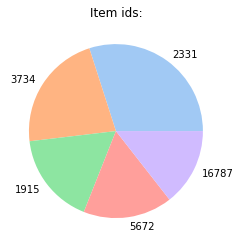

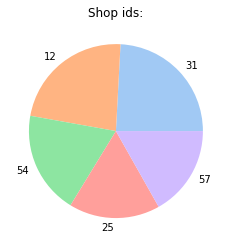

In [9]:
dqc.is_actually_a_return()

Returns happen with a lot of different type of items in a lot of different shops. The dates are also pretty diverse.

In [10]:
dqc.are_there_any_null_values()

['Table items contains 0 empty raws',
 'Table item_categories contains 0 empty raws',
 'Table sales_train contains 0 empty raws',
 'Table sample_submission contains 0 empty raws',
 'Table shops contains 0 empty raws',
 'Table test contains 0 empty raws']

No missing data.

In [11]:
dqc.are_there_any_duplicates()

"The amount of duplicated data in all the tables: 6; Tables with duplicates: ['sales_train']"

Found some duplicated rows. Only 6, so it can be safely deleted or ignored.

There are no numeric columns in items table
There are no numeric columns in item_categories table
There are no numeric columns in shops table
There are no numeric columns in test table


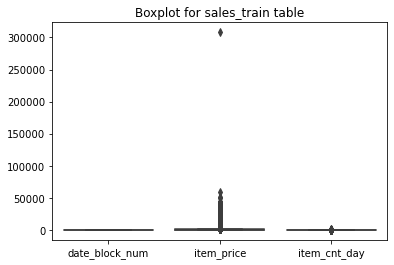

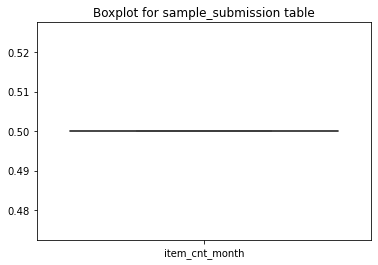

In [12]:
dqc.are_there_any_outliers()

Explicit outliers in item_price.
